In [56]:
# dependencies (numpy, matplotlib, and keras)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, MaxPooling2D, Conv2D,Conv1D, Flatten
from keras.models import Model,Sequential
from keras import backend as K
from keras import objectives
from keras.layers.core import Dense, Dropout, Activation
from keras.datasets import mnist
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import pickle

In [93]:
#PREPARING THE DATA

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
Part2_PLOT = x_test
Part2_PLOT_Colour = y_test

#Making the target categorical
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test,10)

#Splitting the data into three partitions - 70, 20 and 10
X_part1, X_part3, y_part1, y_part3 = train_test_split(x_train, y_train, test_size=0.1)
X_part2 = x_test
y_part2 = y_test


In [94]:
input_shape = 784
batch_size = 100
hidden_dim = 256
features = 5
epoch = 5

#Encoder Begin
X_input = Input(batch_shape = (batch_size,input_shape))
hidden = Dense(hidden_dim, activation='relu')(X_input)

#Begin the Squeeze
mean = Dense(features,name='Mean')
Z_mean = mean(hidden)
variance = Dense(features,name='Variance')
Z_variance = variance(hidden)

In [95]:
#Begin the Sampling function
def sample(args):
    Z_mean, Z_var = args
    epsilon = K.random_normal(shape=(batch_size, features), mean=0.)
    return Z_mean + K.exp(Z_variance / 2) * epsilon

#Wrapping into a tensor shape as above output not the format we want
Z = Lambda(sample, output_shape=(features,),name="Z_Sampling")([Z_mean, Z_variance])

In [96]:
#Decoder begin
dec_hidden = Dense(hidden_dim, activation = 'relu')
decoder_hidden = dec_hidden(Z)
dec_X = Dense(input_shape, activation = 'sigmoid')
decoded_X = dec_X(decoder_hidden)

#Our loss function
def vae_loss(X_input, decoded_X):
    xent_loss = input_shape * objectives.binary_crossentropy(X_input, decoded_X)
    kl_loss = - 0.5 * K.sum(1 + Z_variance - K.square(Z_mean) - K.exp(Z_variance), axis=-1)
    return xent_loss + kl_loss

#We compile our model
vae = Model(X_input, decoded_X)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (100, 784)           0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (100, 256)           200960      input_13[0][0]                   
__________________________________________________________________________________________________
Mean (Dense)                    (100, 5)             1285        dense_25[0][0]                   
__________________________________________________________________________________________________
Variance (Dense)                (100, 5)             1285        dense_25[0][0]                   
__________________________________________________________________________________________________
Z_Sampling

In [97]:
#Train
history = vae.fit(X_part1, X_part1, #Target will be the same as the input as we are trying to reconstruct the same thing
        shuffle=True,
        epochs=epoch,
        batch_size=batch_size,
        validation_data=(X_part2, X_part2),verbose=1)

Train on 54000 samples, validate on 10000 samples
Epoch 1/5
54000/54000 [==============================] - 9s 164us/step - loss: 168.4060 - val_loss: 145.2719
Epoch 2/5
54000/54000 [==============================] - 6s 117us/step - loss: 141.6882 - val_loss: 138.2217
Epoch 3/5
54000/54000 [==============================] - 6s 120us/step - loss: 137.4683 - val_loss: 135.4380
Epoch 4/5
54000/54000 [==============================] - 7s 135us/step - loss: 135.2630 - val_loss: 133.6287
Epoch 5/5
54000/54000 [==============================] - 8s 157us/step - loss: 133.8192 - val_loss: 132.5722


In [ ]:
#We plot the Latent space

#Create an encoder model that has just the encoding layers
encoder = Model(X_input, Z)

#Displaying a scatterplot of our digits and their actual classifictions to see the degree of loss of information
#after being mapped to the latent space

Part2_encoded = encoder.predict(Part2_PLOT, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(Part2_encoded[:, 0], Part2_encoded[:, 1], c=Part2_PLOT_Colour,cmap="viridis")
plt.colorbar()
plt.show()

In [ ]:
#Have to specify the decoder layers again
inputDecoder = Input(shape = (features,))
hiddenLayerDecoder = dec_hidden(inputDecoder)
outputDecoder = dec_X(hiddenLayerDecoder)

#The decoder
decoder = Model(inputDecoder, outputDecoder)

#Generating encoded images
encodedImg = encoder.predict(X_part2, batch_size=batch_size)
#Generating the reconstructed images
decodedImg = decoder.predict(encodedImg, batch_size=batch_size)

In [ ]:
#WARNING - Plotting only works when features is set as 2
grid_x = norm.ppf(np.linspace(0.01, 0.95, 15))
grid_y = norm.ppf(np.linspace(0.01, 0.95, 15))

n = 15
k = 0

plt.figure(figsize=(30,4))
for i,xval in enumerate(grid_x):
    for j,yval in enumerate(grid_y):
        ax = plt.subplot(2, n, k+1)
        f = np.array([[xval,yval]])
        f = decoder.predict(f)
        plt.imshow(f.reshape((28,28)),cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        k+=1

        
        if(k==30):
            break
    if(k==30):
        break

In [92]:
encoded_X = encoder.predict(X_part2, batch_size=batch_size)
encoded_X.shape
test_encoded_X = encoder.predict(X_part3, batch_size=batch_size)

#Writing encoded outputs to file
file = open('encoded.txt', 'wb')
pickle.dump(encoded_X, file)
file.close()
file = open('test_encoded.txt', 'wb')
pickle.dump(test_encoded_X, file)
file.close()

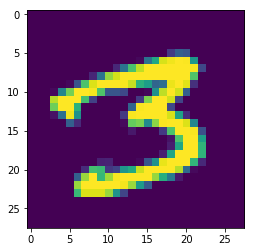

3


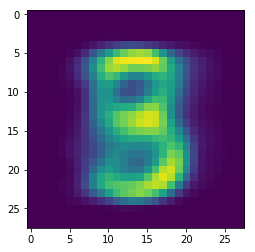

In [79]:
#Check the reconstruction here
num = 993
plt.imshow(X_part3[num].reshape(28,28))
plt.show()

encodImg = np.array([test_encoded_X[num]])
prediction = decoder.predict(encodImg)
plt.imshow(prediction.reshape((28,28)))
print(np.argmax(y_part3[num]))